# Clustering study

As shown in the intial analysis, clustering can reduce the overall error when trying to group nearby postcodes, and reduce API request costs. To maximise the effectiveness of clustering, I will attempt to use 3 different clustering algorithms and preform a parametric study for each, and then I will compare the results

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import requests
import json
from haversine import haversine,Unit
from secret import apikey

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import scipy.stats

pd.options.mode.chained_assignment = None

worklat=51.4229
worklong=-0.2092

payload = {}
headers = {}

<h1>K-Means

In [2]:
df=pd.read_csv('Croydon.csv')
df=df[df['Latitude']>=45] 
df=df[df['In Use?']=='Yes']
df=df[['Postcode','Latitude','Longitude']]

minlat=df['Latitude'].min()
maxlat=df['Latitude'].max()
minlong=df['Longitude'].min()
maxlong=df['Longitude'].max()

scaler=MinMaxScaler()
scaler.fit(df[['Latitude']])
df['Latitude']=scaler.transform(df[['Latitude']])
scaler.fit(df[['Longitude']])
df['Longitude']=scaler.transform(df[['Longitude']])
df1=df

In [3]:
df

,Postcode,Latitude,Longitude
0,BR3 3BZ,0.653281,0.981860
3,CR0 0XD,0.624888,0.513235
6,CR0 0XJ,0.585465,0.503754
8,CR0 0XT,0.623839,0.560232
9,CR0 0XZ,0.479714,0.383575
...,...,...,...
13179,SW16 5TR,0.917151,0.321044
13180,SW16 5TS,0.913756,0.329393
13181,SW16 5TT,0.902774,0.337272
13182,SW16 5TU,0.902336,0.334136


In [4]:
data=[]
for kclusters in range(5,1000,50):

    df=pd.read_csv('Croydon.csv')
    df=df[df['Latitude']>=45] 
    df=df[df['In Use?']=='Yes']
    df=df[['Postcode','Latitude','Longitude']]

    minlat=df['Latitude'].min()
    maxlat=df['Latitude'].max()
    minlong=df['Longitude'].min()
    maxlong=df['Longitude'].max()

    scaler=MinMaxScaler()
    scaler.fit(df[['Latitude']])
    df['Latitude']=scaler.transform(df[['Latitude']])
    scaler.fit(df[['Longitude']])
    df['Longitude']=scaler.transform(df[['Longitude']])
    df1=df

    km=KMeans(n_clusters=kclusters)
    km.fit(df[['Latitude','Longitude']])
    y_predicted=km.fit_predict(df[['Latitude','Longitude']])
    df['Cluster ID']=y_predicted
    df['Cluster Latitude']=km.cluster_centers_[df['Cluster ID'],0]
    df['Cluster Longitude']=km.cluster_centers_[df['Cluster ID'],1]
    df['Latitude']=minlat+df['Latitude']*(maxlat-minlat)
    df['Cluster Latitude']=minlat+df['Cluster Latitude']*(maxlat-minlat)
    df['Longitude']=minlong+df['Longitude']*(maxlong-minlong)
    df['Cluster Longitude']=minlong+df['Cluster Longitude']*(maxlong-minlong)
    df.loc[:,'Distance (m)']=[haversine((df['Cluster Latitude'][i],df['Cluster Longitude'][i]),(df['Latitude'][i],df['Longitude'][i]), unit=Unit.METERS) for i in df.index]
    dict={
        'Number of clusters':df['Cluster ID'].nunique(),
        "Total cost ($)": round(kclusters*(12/1000),2),
        'Mean Distance (m)':round(df['Distance (m)'].mean()),
        'Max Distance (m)':round(df['Distance (m)'].max())
    }
    data.append(dict)
    df=df1
kmeansdata=pd.DataFrame(data)

In [5]:
kmeansdata

,Number of clusters,Total cost ($),Mean Distance (m),Max Distance (m)
0,5,0.06,1466,4647
1,55,0.66,399,1439
2,105,1.26,275,1013
3,155,1.86,222,805
4,205,2.46,192,884
5,255,3.06,171,649
6,305,3.66,153,649
7,355,4.26,141,782
8,405,4.86,131,478
9,455,5.46,122,555


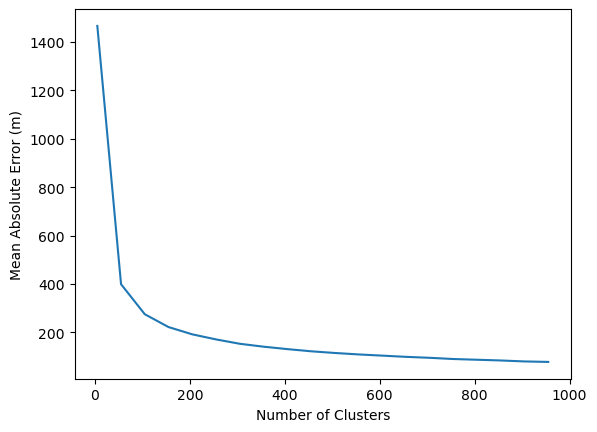

In [10]:
ax=sns.lineplot(x=kmeansdata['Number of clusters'], y=kmeansdata['Mean Distance (m)'])

ax.set(ylabel='Mean Absolute Error (m)', xlabel='Number of Clusters')
plt.show()

<h1>GMM

In [11]:
df=pd.read_csv('Croydon.csv')

In [32]:
searches=[]
for y in range(1,1000,50):
    print(f'y={y}')
    X=df[['Longitude','Latitude']]
    EM=GaussianMixture(n_components=y)
    EM.fit(X)
    cluster=EM.predict(X)

    df1=df[['Postcode','Latitude','Longitude']]
    df1['Cluster ID']=cluster

    centers = np.empty(shape=(EM.n_components, X.shape[1]))
    for i in range(EM.n_components):
        density = scipy.stats.multivariate_normal(cov=EM.covariances_[i], mean=EM.means_[i]).logpdf(X)
        centers[i, :] = X.loc[np.argmax(density)]


    df1['Cluster Latitude']=centers[df1['Cluster ID'],1]
    df1['Cluster Longitude']=centers[df1['Cluster ID'],0]
    df1['Distance']=((((df1['Latitude']-df1['Cluster Latitude'])**2)+((df1['Longitude']-df1['Longitude'])**2))**0.5)*(1.11/	0.00001)
    dict={
        'Number of clusters':y,
        "Total cost ($)": round(y*(12/1000),2),
        'Mean Distance (m)':round(df1['Distance'].mean()),
        'Max Distance (m)':round(df1['Distance'].max())
    }

    searches.append(dict)
gmmdata=pd.DataFrame(searches)

y=1
y=51
y=101
y=151
y=201
y=251
y=301
y=351
y=401
y=451
y=501
y=551
y=601
y=651
y=701
y=751
y=801
y=851
y=901
y=951


In [33]:
gmmdata

,Number of clusters,Total cost ($),Mean Distance (m),Max Distance (m)
0,1,0.01,2903,8348
1,51,0.61,259,1817
2,101,1.21,177,1531
3,151,1.81,141,1426
4,201,2.41,129,1294
5,251,3.01,127,1294
6,301,3.61,125,1294
7,351,4.21,126,916
8,401,4.81,125,1071
9,451,5.41,121,1071


<h1>DBSCAN

In [15]:
df1=pd.read_csv('Croydon.csv')
df=df1[['Postcode','Latitude','Longitude']]

In [16]:
tempdata=[]
for epsilon in np.arange(0.0005,0.003,0.00005):
    df=df1[['Postcode','Latitude','Longitude']]
    X=df[['Longitude','Latitude']]
    db1=DBSCAN(eps=epsilon, min_samples=1).fit(X)
    df.loc[:,'Cluster ID']=db1.labels_
    numclusters=int(df['Cluster ID'].nunique())
    
    dictlat={}
    dictlong={}
    for i in (i for i in df['Cluster ID'].unique() if i!=-1):
        dictlat[i]=df[df['Cluster ID']==i]['Latitude'].mean()
        dictlong[i]=df[df['Cluster ID']==i]['Longitude'].mean()

    df.loc[:,'Clusterid2']=df['Cluster ID']
    df.loc[:,'Clusterid1']=df['Cluster ID']
    df.replace({"Clusterid1": dictlat},inplace=True)
    df.replace({"Clusterid2": dictlong},inplace=True)
    df.rename(columns={'Clusterid1':'Cluster Latitude', 'Clusterid2':'Cluster Longitude'}, inplace=True)

    distances=[]
    for i in df.index:
        if df['Cluster Latitude'][i]!=-1:
            try:
                distances.append(haversine((df['Cluster Latitude'][i],df['Cluster Longitude'][i]),(df['Latitude'][i],df['Longitude'][i]),unit=Unit.METERS))
            except:
                distances.append('bad')
        else:
            distances.append(0)

    df.loc[:,'Distance']=distances
    dict={
    "EPS":epsilon,  
    "Clusters" : numclusters,
    "Noise" : df[df['Cluster ID']==-1].shape[0],
    "Total searches" : df[df['Cluster ID']==-1].shape[0]+df['Cluster ID'].nunique(),
    "Total cost ($)": round((df[df['Cluster ID']==-1].shape[0]+df['Cluster ID'].nunique())*(12/1000),2),
    'Mean Distance (m)':df['Distance'].mean(),
    'Max Distance (m)':df['Distance'].max(),
    }
    tempdata.append(dict)
dbscandata=pd.DataFrame(tempdata)

In [17]:
dbscandata

,EPS,Clusters,Noise,Total searches,Total cost ($),Mean Distance (m),Max Distance (m)
0,0.00050,5414,0,5414,64.97,12.216704,257.122586
1,0.00055,4875,0,4875,58.50,17.119350,280.686387
2,0.00060,4295,0,4295,51.54,26.586360,663.226968
3,0.00065,3788,0,3788,45.46,34.719383,679.249795
4,0.00070,3256,0,3256,39.07,53.952469,790.655473
5,0.00075,2759,0,2759,33.11,71.843812,992.879765
6,0.00080,2327,0,2327,27.92,105.499199,1448.385046
7,0.00085,1939,0,1939,23.27,194.341215,2417.867850
8,0.00090,1444,0,1444,17.33,433.529135,3258.701334
9,0.00095,1198,0,1198,14.38,953.992671,3850.900302


<h1>Plots

C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_18088\2006802792.py:8: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([ax1,ax2,ax3],labels=['K-Means','GMM','DBSCAN'])


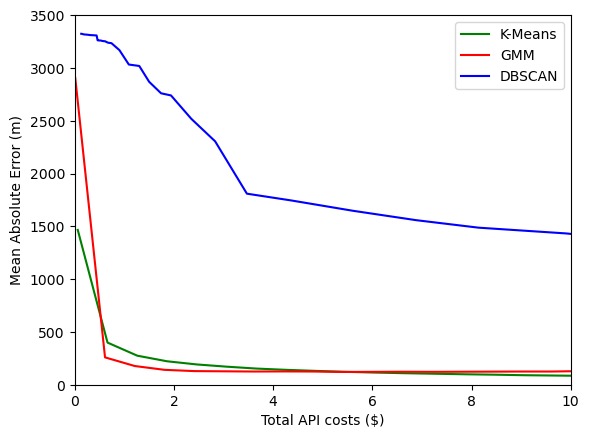

In [71]:
fig, ax = plt.subplots()
ax1=ax.plot(kmeansdata['Total cost ($)'],kmeansdata['Mean Distance (m)'],color='green')
ax2=ax.plot(gmmdata['Total cost ($)'],gmmdata['Mean Distance (m)'],color='red')
ax3=ax.plot(dbscandata['Total cost ($)'],dbscandata['Mean Distance (m)'],color='blue')
ax.set_xlim(xmin=0, xmax=10)
ax.set_ylim(ymin=0, ymax=3500)
ax.set(xlabel='Total API costs ($)',ylabel='Mean Absolute Error (m)')
ax.legend([ax1,ax2,ax3],labels=['K-Means','GMM','DBSCAN'])


C:\Users\EamonSaeid\AppData\Local\Temp\ipykernel_18088\4031344187.py:8: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([ax1,ax2,ax3],labels=['K-Means','GMM','DBSCAN'])


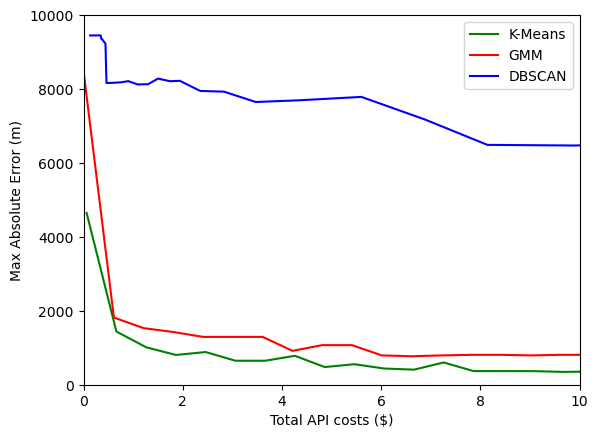

In [74]:
fig, ax = plt.subplots()
ax1=ax.plot(kmeansdata['Total cost ($)'],kmeansdata['Max Distance (m)'],color='green')
ax2=ax.plot(gmmdata['Total cost ($)'],gmmdata['Max Distance (m)'],color='red')
ax3=ax.plot(dbscandata['Total cost ($)'],dbscandata['Max Distance (m)'],color='blue')
ax.set_xlim(xmin=0, xmax=10)
ax.set_ylim(ymin=0, ymax=10000)
ax.set(xlabel='Total API costs ($)',ylabel='Max Absolute Error (m)')
ax.legend([ax1,ax2,ax3],labels=['K-Means','GMM','DBSCAN'])
